In [4]:
from __future__ import annotations

from collections import Counter, defaultdict
from dataclasses import dataclass
import functools
import random

# Moves and States of the game

In [5]:
@dataclass
class Move:
  """A move in a hexapawn game.
  """
  src: tuple[int]  # row, col
  dst: tuple[int]  # row, col

  def __hash__(self):
    return hash(self.src) ^ hash(self.dst)

  @staticmethod
  def parse(move: str) -> Move:
    """Convert a string like 'a1 a2' to a move.
    """
    src, dst = move.split(' ')
    return Move(Move._parseloc(src), Move._parseloc(dst))

  @staticmethod
  def _parseloc(loc: str) -> tuple[int]:
    """Convert something like b2 to a pair of ints.
    """
    file, rank = loc[0], loc[1]
    return 3 - int(rank), ord(file) - ord('a')

  def __str__(self) -> str:
    """Return a parseable string."""
    col_map = 'abc'
    row_map = '321'
    i, j = self.src
    i1, j1 = self.dst
    return f'{col_map[j]}{row_map[i]} {col_map[j1]}{row_map[i1]}'

In [6]:
WHITE = '♙'
BLACK = '♟'
EMPTY = '·'
SQUARE = {1: WHITE, -1: BLACK, 0: EMPTY}
PLAYER = {1: 'w', -1: 'b', 0: '?'}

@dataclass
class State:
  """Game state for hexapawn.

  board is 3x3 matrix of 0 (unoccupied), white pawn (+1), or black pawn (-1)
  to_play is +1 or -1
  """
  board: tuple[tuple[int]]
  to_play: int
  winner: int = 0
  moves: list[Move] | None = None

  def __post_init__(self):
    """Cache the set of possible moves and if there is a winner.
    """
    self.moves = self._compute_moves()
    self.winner = self._compute_winner()

  def _compute_moves(self) -> list[Move]:
    """Compute possible moves from this state."""
    def on_board(i, j) -> bool:
      """Is position i,j on the board?"""
      return 0 <= i < 3 and 0 <= j < 3
    moves = []
    row_dir = -self.to_play # direction of movement
    # pieces the player can move
    moveable_pieces = [
        (i,j) for i in range(3) for j in range(3)
        if self.board[i][j] == self.to_play]
    for i, j in moveable_pieces:
      # push the pawn forward if possible
      i1 = i + row_dir
      if on_board(i1, j) and self.board[i1][j] == 0:
        moves.append(Move(src=(i, j), dst=(i1, j)))
      # capture with the pawn if possible
      for j1 in [j - 1, j + 1]:
        if on_board(i1, j1) and self.board[i1][j1] == -self.to_play:
          moves.append(Move(src=(i, j), dst=(i1, j1)))
    return moves

  def _compute_winner(self):
    """See if there is a winner for this position."""
    # if a pawn is on the back row for player they win
    for player, back_row in [(-1, 2), (+1, 0)]:
      if player in self.board[back_row]:
        return player
    # if the player can't move they lose
    if not self.moves:
      return -self.to_play
    return 0

  @staticmethod
  def initial() -> State:
    """Initial state of board."""
    return State(to_play=1, board=((-1,-1,-1),(0,0,0),(1,1,1)))

  def render(self) -> str:
    """View the state as a string."""
    status = f'{PLAYER[self.to_play]}'
    if self.winner:
      status += f' {PLAYER[self.winner]} won'
    return f'{status}\n{self.render_board()}'

  def render_board(self) -> str:
    """View the board as a string."""
    def _render_row(self, row):
      return ''.join([f'{SQUARE[j]}' for j in row])
    return f'\n'.join([self._render_row(js) for js in self.board])

  def __hash__(self):
    return hash(self.board) ^ hash(self.to_play)

  def children(self) -> list[State]:
    """All possible states that can be reached from this state."""
    return [] if self.winner else [self.apply(m) for m in self.moves]

  def apply(self, move: Move) -> State:
    """Apply a move and return the resulting state."""
    mutable_board = [list(list(row)) for row in self.board]
    i, j = move.src
    mutable_board[i][j] = 0
    i1, j1 = move.dst
    mutable_board[i1][j1] = self.to_play
    return State(
        board=tuple(tuple(row) for row in mutable_board),
        to_play=-self.to_play)

# Game Trees

In [15]:
@dataclass
class GameTree:
  """A game tree.
  """
  root: State
  children: dict[State, list[State]] | None = None

  @staticmethod
  def rooted_at(root:State) -> GameTree:
    """Build a complete game tree.
    """
    tree = GameTree(root=root, children={})
    tree._expand(root)
    return tree

  def _expand(self, state) -> GameTree:
    self.children[state] = state.children()
    for child in self.children[state]:
      if child not in self.children:
        self._expand(child)

  def __len__(self) -> int:
    return len(self.children)

  def pprint(self, root=None, depth=0, max_depth=3, fanout=99):
    """Print the game tree.
    """
    if depth >= max_depth:
      return
    state = self.root if root is None else root
    tab = '|  ' * depth
    for line in state.render().split('\n'):
      print(f'{tab}{line}')
    for child in self.children[r][:fanout]:
      self.pprint(child, depth+1, max_depth, fanout)

## Checking sizes

Full tree is 163 nodes, but one move in is only 58 or 94.

In [18]:
tree = GameTree.rooted_at(State.initial())
first_white_moves = [f'{file}1 {file}2' for file in 'abc']
subtrees = {
    move: GameTree.rooted_at(State.initial().apply(Move.parse(move)))
    for move in first_white_moves}

print(f'full tree has {len(tree)} nodes')
for move, subtree in subtrees.items():
  print(f'after {move} subtree has {len(subtree)} nodes')

full tree has 135 nodes
after a1 a2 subtree has 53 nodes
after b1 b2 subtree has 80 nodes
after c1 c2 subtree has 53 nodes


## Checking sizes after checking for symmetries

Only 33 if you consider horizontal reflections,
vertical 'flips', and inverting the player. (There's a bit of logic involved to adjust strategies in the last two cases!)

In [6]:
def reflect(board):
  return tuple(tuple(reversed(row)) for row in board)
def flip(board):
  return tuple(reversed(board))
def invert(board):
  return tuple(tuple(-j for j in row) for row in board)

def symettries(state):
  """Return the reflection of a state.
  """
  result = {state.board}
  #for transform in [reflect, flip, invert]:
  for transform in [reflect]:
    for b in list(result):
      result.add(transform(b))
  return result

def to_play(state, player):
  return player is None or state.to_play == player

def possible(tree, symset, player):
  return {
      s for s in tree.children
      if to_play(s, player) and s.board in symset}

def state_groupings(tree, player=None):
  groups = defaultdict(set)
  for i, state in enumerate(tree.children):
    if not to_play(state, player):
      continue
    variants = possible(tree, symettries(state), player)
    canonical = sorted(variants, key=lambda s:s.board)[0]
    groups[canonical].add(state)
  print(f'original states: {len(tree.children)}')
  print(f'canonical states: {len(groups)}')
  return groups

In [7]:
_ = state_groupings(tree, player=-1)
_ = state_groupings(subtree, player=-1)
_ = state_groupings(subtree1, player=-1)

original states: 163
canonical states: 34
original states: 58
canonical states: 26
original states: 94
canonical states: 19


In [8]:
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
def viz(tree):
  g = nx.Graph()
  idx = {
      s:s.render_board()
      for i, s in enumerate(tree.children)
      }
  state = {b:s for s, b in idx.items()}
  for parent, children in tree.children.items():
    g.add_edges_from([(idx[parent], idx[child]) for child in children])

  plt.figure(figsize=(12, 8))
  pos = nx.bfs_layout(g, start=idx[tree.root], align='horizontal', scale=20)
  #pos = nx.forceatlas2_layout(g)
  #pos = nx.kamada_kawai_layout(g, scale=10000)
  #pos = nx.spectral_layout(g)
  #pos = nx.shell_layout(g)
  def win_color(b):
    return {0: 'white', 1: 'black', -1: 'red'}[state[b].winner]
  win_colors = [win_color(b) for b in g]
  nx.draw_networkx(
    g, pos=pos,
    font_size=8, font_family='monospace', edgecolors=win_colors,
    node_size=600, node_color='#f1f1f1', node_shape='s')
  plt.show()

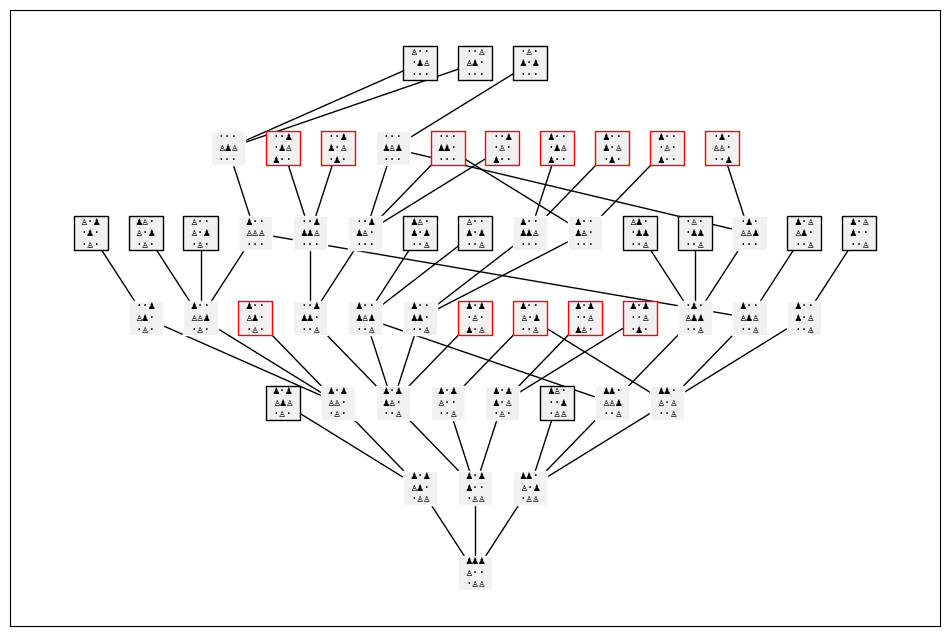

In [13]:
viz(subtree)

In [14]:
@dataclass
class Hexapawn:
  """A game of hexapawn.
  """
  tree: GameTree | None = None
  record: Counter | None = None

  def __post_init__(self):
    if self.tree is None:
      self.tree = GameTree.rooted_at(State.initial())
    if self.record is None:
      self.record = Counter()

  def player_str(self, p):
    return {1: 'white', -1: 'black'}[p]

  def tourney(self):
    while True:
      for p in self.record:
        print(f'{p} wins: {self.record[p]}')
      winner = self.game()
      self.record[self.player_str(winner)] += 1

  def game(self):
    state = self.tree.root
    while True:
      print(state.render())
      if state.winner:
        print(f'{self.player_str(state.winner)} wins!')
        return state.winner
      if state.to_play == 1:
        move = self.input_white_move(state)
        state = state.apply(move)
      else:
        state = random.choice(tree.children[state])

  def input_white_move(self, state: State) -> Move:
    """Input a move for white.
    """
    def report_problem(move_str:str, issue: str):
      print(f'{issue} move "{move_str}"')
      print('your options are:', [str(m) for m in state.moves])
    while True:
      move_str = input('your move? ')
      try:
        move = Move.parse(move_str)
        if move not in state.moves:
          report_problem(move_str, 'illegal')
          continue
      except Exception as ex:
        report_problem(move_str, f'syntactically incorrect [{ex=}]')
        continue
      return move

In [15]:
Hexapawn().tourney()

None win:? play:w
♟♟♟
···
♙♙♙
your move? a1 a2
a1 a2 win:? play:b
♟♟♟
♙··
·♙♙
b3 a2 win:? play:w
♟·♟
♟··
·♙♙
your move? b1 a2
b1 a2 win:? play:b
♟·♟
♙··
··♙
c3 c2 win:b play:w
♟··
♙·♟
··♙
black wins!
black wins: 1
None win:? play:w
♟♟♟
···
♙♙♙
your move? a1 a2
a1 a2 win:? play:b
♟♟♟
♙··
·♙♙
b3 a2 win:? play:w
♟·♟
♟··
·♙♙
your move? b1 b2
b1 b2 win:? play:b
♟·♟
♟♙·
··♙
c3 c2 win:? play:w
♟··
♟♙♟
··♙
your move? b2 a3
b2 a3 win:w play:b
♙··
♟·♟
··♙
white wins!
black wins: 1
white wins: 1
None win:? play:w
♟♟♟
···
♙♙♙
your move? quit
syntactically incorrect [ex=ValueError('not enough values to unpack (expected 2, got 1)')] move "quit"
your options are: ['a1 a2', 'b1 b2', 'c1 c2']


KeyboardInterrupt: Interrupted by user